# What is portfolio optimization?

Given a list of assets, the aim is to allocate resources. That is, we would like a way to divide the total investment between assets. Depending on one's investment goals this can be done in many ways. One of the simplest, most common and popular criteria is to maximise returns while minimising risk. One can also choose to do the following. 

 - maximise returns without consideration for risk
 - minimise risk without consideration for returns
 - maximise diversification (maximise asset classes)
 - choose decorrelated assets

In todays example we will choose five ETFs and allocate them

# What are ETFs?

ETFs or Exchange-Traded Funds are diversified funds (portfolios) that are traded on various stock exchanges just like shares. ETFs are similar to managed funds in the sense that they both consist of numerous other assets on the exchange but unlike managed funds, ETFs simply track an index and as such have lower fees.

# Let's get started

In [1]:
import pandas as pd
# the yahoo-finance package let's us download asset data 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
from scipy import stats

np.random.seed(2718)

## Data

In [2]:
# Stock market data

ticker = yf.Ticker('ETHI.AX')
#get the historical prices for this ticker
tickerdf = ticker.history(period='max')
tickerdf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-05,5.56,5.56,5.56,5.56,0,0.0,0
2017-01-06,5.61,5.61,5.61,5.61,0,0.0,0
2017-01-09,5.62,5.63,5.62,5.63,885185,0.0,0
2017-01-10,5.58,5.58,5.58,5.58,330,0.0,0
2017-01-11,5.61,5.61,5.59,5.59,60602,0.0,0
...,...,...,...,...,...,...,...
2020-06-09,10.60,10.69,10.60,10.69,69344,0.0,0
2020-06-10,10.77,10.80,10.72,10.72,55822,0.0,0
2020-06-11,10.79,10.79,10.61,10.61,101025,0.0,0


**choose five assets from [here](https://www.morningstar.com.au/ETFs/PerformanceTable) or continue with the ones I chose**

In [3]:
tickers = ['RARI.AX','ETHI.AX','IEM.AX','IAF.AX','GOLD.AX'] # also check out VAS and IOO instead of RARI and ETHI

for tic in tickers:
    #get data on this ticker
    ticker = yf.Ticker(tic)
    #get the historical prices for this ticker
    tickerdf = ticker.history(period='max')[['Close']]
    tickerdf.rename(columns={'Close': tic[:-3]}, inplace=True)
    if tic == 'RARI.AX':
        df = tickerdf
    else:
        df = df.join(tickerdf, how='inner', rsuffix='_'+tic)


#see your data
df

,RARI,ETHI,IEM,IAF,GOLD
Date,,,,,
2017-01-05,20.30,5.56,45.60,98.22,152.84
2017-01-06,20.29,5.61,45.50,98.33,153.00
2017-01-09,20.52,5.63,45.47,97.99,152.82
2017-01-10,20.35,5.58,45.36,98.19,152.84
2017-01-11,20.35,5.59,45.59,98.26,153.00
...,...,...,...,...,...
2020-06-09,22.55,10.69,58.87,115.59,227.62
2020-06-10,22.55,10.72,58.72,115.85,230.50
2020-06-11,21.69,10.61,58.24,116.34,234.22


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b9833971f28>,
      dtype=object)

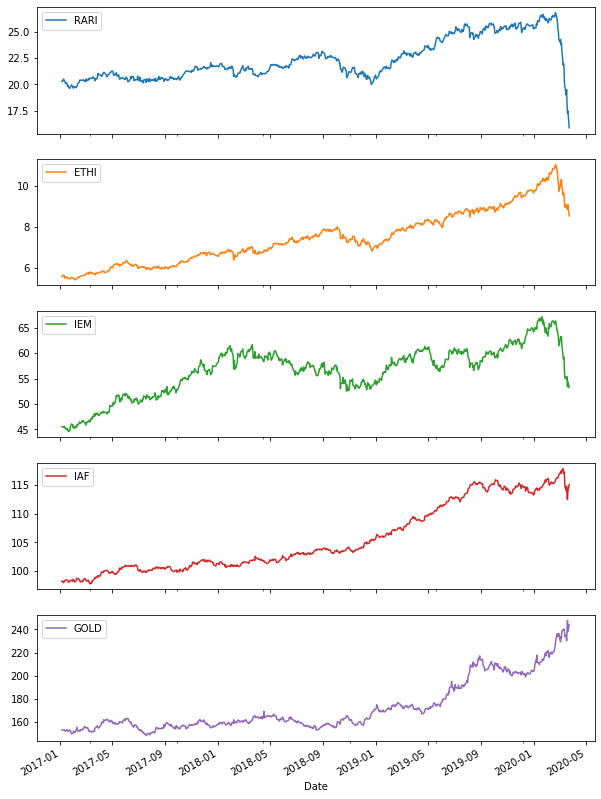

In [5]:
df.plot(subplots=True, figsize=(10,15))

In [6]:
# Calculate daily returns
returns = df.pct_change()

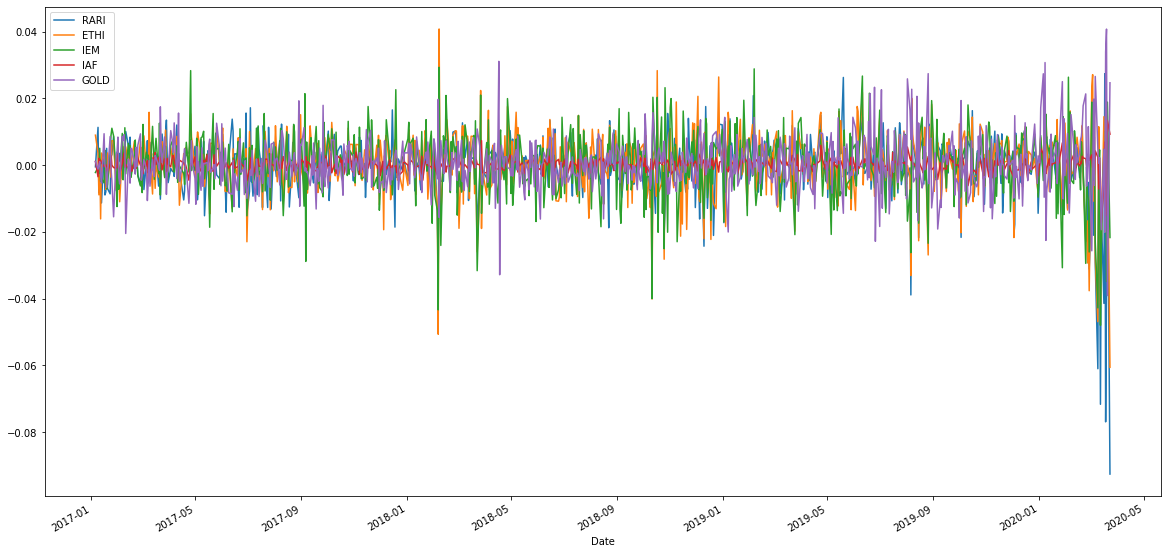

In [7]:
returns.plot(figsize=(20,10))

## Monte Carlo Approach

The risk free rate is the interest a hypothetical investment with no risk of loss is expected to earn over a given period. This is usually calculated based on a risk-free government bond. 

For our purposes we can find out the Australian risk free rate [here](https://tradingeconomics.com/australia/government-bond-yield).

In [8]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker[:-3] for ticker in tickers])
        
    return results_df

In [9]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.3/100

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

In [116]:
mean_returns, cov

(RARI   -0.000145
 ETHI    0.000646
 IEM     0.000261
 IAF     0.000186
 GOLD    0.000577
 dtype: float64,           RARI          ETHI       IEM           IAF      GOLD
 RARI  0.000075  4.288086e-05  0.000037  1.444276e-06 -0.000019
 ETHI  0.000043  7.963209e-05  0.000053 -9.649073e-07 -0.000011
 IEM   0.000037  5.284921e-05  0.000085 -1.609424e-06 -0.000014
 IAF   0.000001 -9.649073e-07 -0.000002  4.109493e-06  0.000004
 GOLD -0.000019 -1.084926e-05 -0.000014  4.070782e-06  0.000059)

Note that the covariance between ETHI and the other assets, and between IAF and other assets is low. Also GOLD return is highest, so these three are likely to get highest allocation.

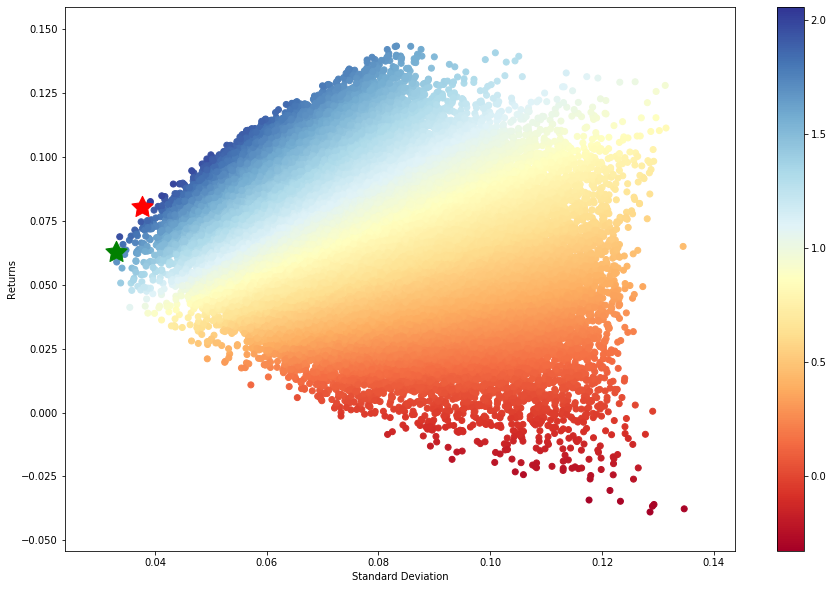

In [10]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

In [11]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,RARI,ETHI,IEM,IAF,GOLD
98141,0.080375,0.037657,2.0547,0.003929,0.135858,0.030918,0.654077,0.175218


In [12]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,RARI,ETHI,IEM,IAF,GOLD
66033,0.062837,0.032951,1.815943,0.035729,0.050453,0.020761,0.773631,0.119425


It looks like neither portfolio assigned any weight to RARI. However, generally it is not a good idea to drop the only ETF based on local Australian assets (1) because this reduces diversification of our portfolio, and (2) the other ETFs that do not contain any local Aus assets compound the foreign currency exchange rate volatility.

As such we will redo the above while restricting ourselves to a period before the COVID-19 related chaos. 

### Before COVID-19

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b983395fb38>,
      dtype=object)

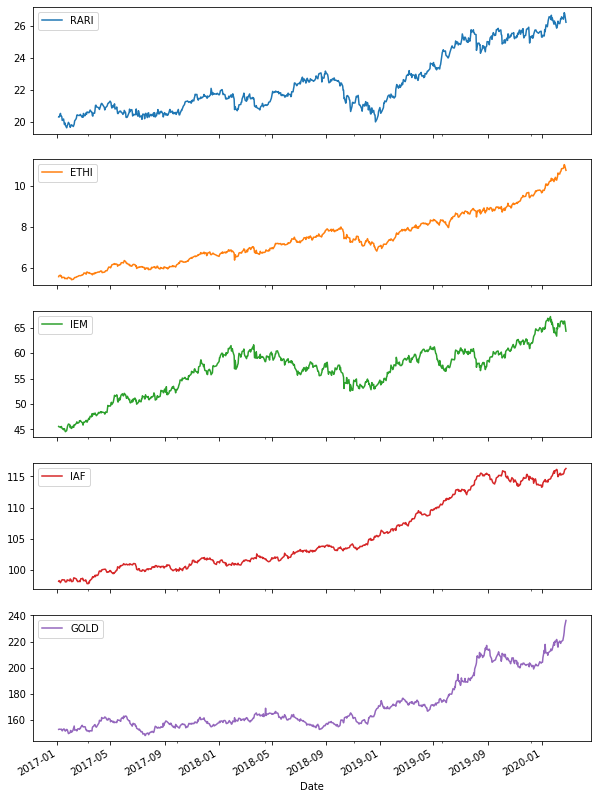

In [13]:
tickers = ['RARI.AX','ETHI.AX','IEM.AX','IAF.AX','GOLD.AX'] # also check out VAS and IOO instead of RARI and ETHI

for tic in tickers:
    #get data on this ticker
    ticker = yf.Ticker(tic)
    #get the historical prices for this ticker
    tickerdf = ticker.history(period='max', end='2020-02-25')[['Close']]
    tickerdf.rename(columns={'Close': tic[:-3]}, inplace=True)
    if tic == 'RARI.AX':
        df = tickerdf
    else:
        df = df.join(tickerdf, how='inner', rsuffix='_'+tic)

df.plot(subplots=True, figsize=(10,15))

In [14]:
returns = df.pct_change()

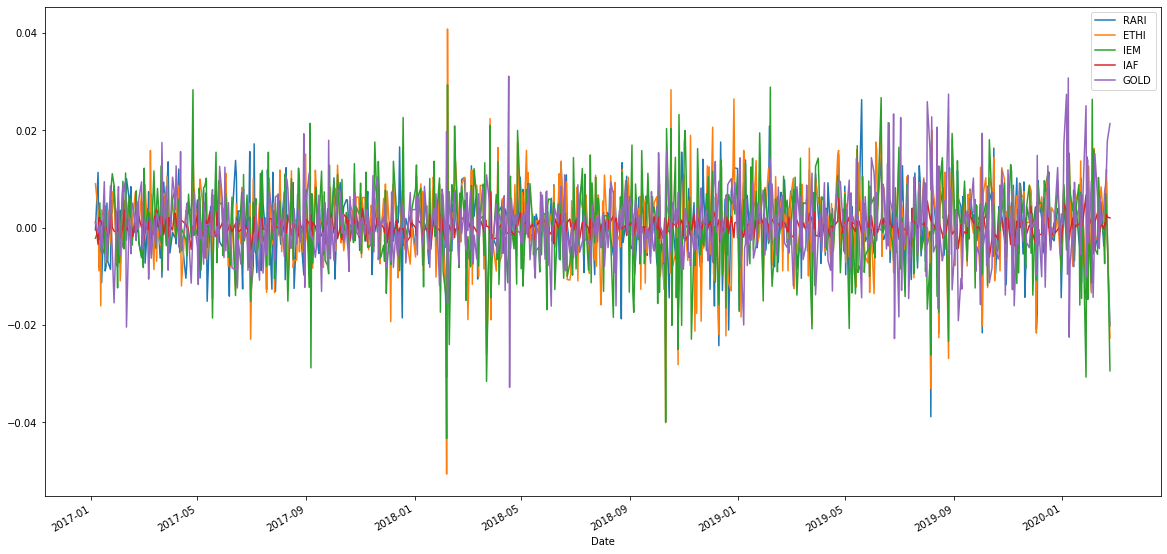

In [15]:
returns.plot(figsize=(20,10))

In [16]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.3/100

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

In [17]:
mean_returns, cov

(RARI    0.000348
 ETHI    0.000869
 IEM     0.000473
 IAF     0.000215
 GOLD    0.000576
 dtype: float64,           RARI      ETHI       IEM       IAF      GOLD
 RARI  0.000048  0.000031  0.000027 -0.000001 -0.000012
 ETHI  0.000031  0.000067  0.000045 -0.000001 -0.000009
 IEM   0.000027  0.000045  0.000076 -0.000002 -0.000012
 IAF  -0.000001 -0.000001 -0.000002  0.000003  0.000005
 GOLD -0.000012 -0.000009 -0.000012  0.000005  0.000052)

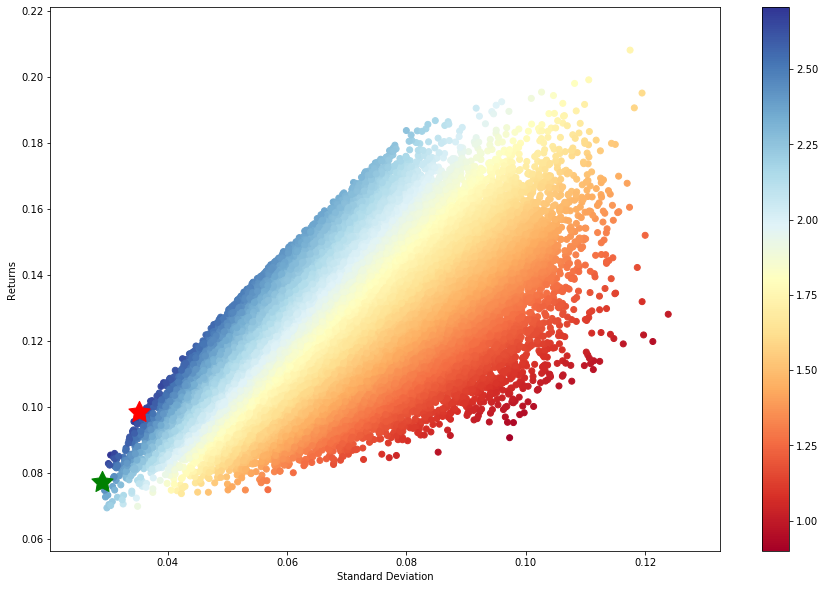

In [18]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

In [19]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,RARI,ETHI,IEM,IAF,GOLD
52414,0.098454,0.035289,2.704912,0.016452,0.177713,0.015381,0.642072,0.148383


In [20]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,RARI,ETHI,IEM,IAF,GOLD
67187,0.077266,0.029057,2.555866,0.073553,0.082569,0.057946,0.749518,0.036414


**That's more like it!**

But the whole approach seems pretty volatile! As in if you rerun the simulation you get quite a different max_sharpe portfolio with a similar return and std!

## Functional optimisation with Scipy

In [21]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf, bounds=None):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    if bounds == None:
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

In [22]:
pd.DataFrame([round(x,4) for x in optimal_port_sharpe['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.011,0.1694,0.0036,0.7276,0.0883


In [23]:
weights = np.array([x for x in optimal_port_sharpe['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0907, std dev = 0.0320, sharpe ratio = 2.7404


In [24]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov, bounds=None):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    if bounds == None:
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_variance = min_variance(mean_returns, cov)

In [25]:
pd.DataFrame([round(x, 4) for x in min_port_variance['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.0452,0.0089,0.0409,0.9049,0.0


In [26]:
weights = np.array([x for x in min_port_variance['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Min variance portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Min variance portfolio return = 0.0598, std dev = 0.0253, sharpe ratio = 2.2468


We are still not allocating much weight to RARI and IEM. Let us try and force scipy to allocate some weight to RARI and IEM.

In [27]:
bounds = ((0.1,1),(0.0,1.0),(0.05,1),(0.0,1.0),(0.0,1.0))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [28]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.1,0.1068,0.05,0.621,0.1222


In [29]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0894, std dev = 0.0333, sharpe ratio = 2.5997


With the extra constraint on the weights of RARI and IEM, we get approximately 0.13% less return and around 0.1% higher std. I think this is acceptable!

## Efficient Frontier

In [30]:
def efficient_return(mean_returns, cov, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    rf = 0.0 #does not matter because we are not using the sharpe ratio here
    
    def portfolio_return(weights):
        return calc_portfolio_perf(weights, mean_returns, cov, rf)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov, ret))
    return efficients

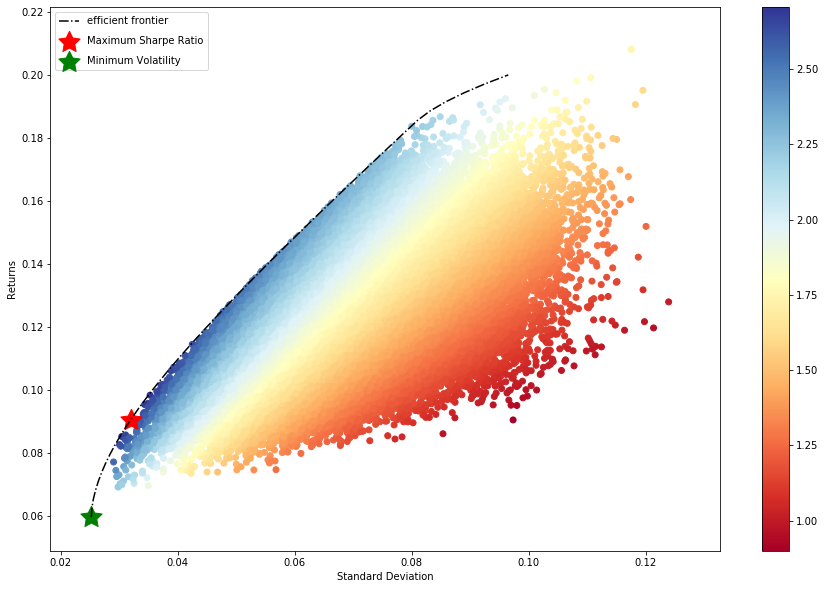

In [31]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = calc_portfolio_perf(np.array([x for x in optimal_port_sharpe['x']]), mean_returns, cov, rf)
#locate positon of portfolio with minimum standard deviation
min_vol_port = calc_portfolio_perf(np.array([x for x in min_port_variance['x']]), mean_returns, cov, rf)
target = np.linspace(min_vol_port[0], 0.2, 50)
efficient_portfolios = efficient_frontier(mean_returns, cov, target)

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot efficient frontier
plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500,label='Maximum Sharpe Ratio')
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500,label='Minimum Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.show()

In [33]:
an_vol = np.std(returns) * np.sqrt(252)
an_rt = mean_returns * 252

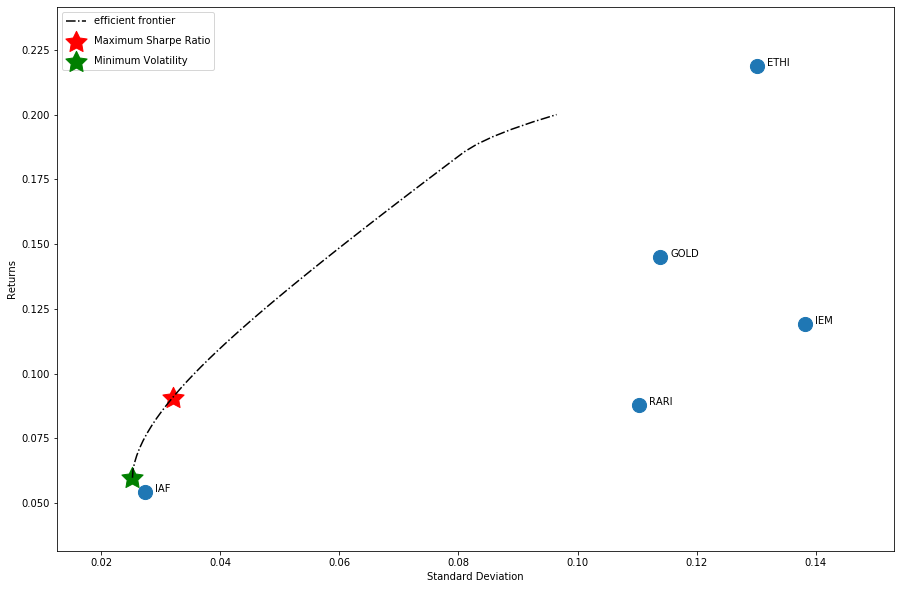

In [34]:
#create scatter plot coloured by Sharpe Ratio
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(an_vol,an_rt,marker='o',s=200)
for i, txt in enumerate(df.columns):
    ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
#plot efficient frontier
ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500,label='Maximum Sharpe Ratio')
#plot green star to highlight position of minimum variance portfolio
ax.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500,label='Minimum Volatility')
ax.legend(labelspacing=1, loc='upper left')